In [1]:
cd ../..

/Users/joeranbosma/stack/Projects/M5Forecast


In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os, gc
import matplotlib.pyplot as plt

import lightgbm as lgb

# own imports
from evaluation import Referee, load_data, select_dates, select_day_nums
from train import get_chronological_train_val_split, get_train_val_slit, train_lightgbm_model, lightgbm_pred_to_df

# Setup file paths
data_dir = 'data/'
os.environ['DATA_DIR'] = data_dir
sub_dir = 'submissions_uncertainty/'
plt.rcParams['font.size'] = 13

# Hardcode requested quantiles
quantiles = [0.005, 0.025, 0.165, 0.25, 0.5, 0.75, 0.835, 0.975, 0.995]

# Predict LightGBM - multiple levels - 5-fold chronological cross-validation

In [4]:
model_dir = 'models/uncertainty/train_lightgbm_events/run1/'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

## Predict validation sets

In [5]:
level = 3
fold = 3
print("== Starting fold {} ==".format(fold))
# read
train, val, test, features = get_train_val_slit(level, fold)
model = lgb.Booster(model_file=model_dir + "lightgbm-level{}-fold{}.txt".format(level, fold))

# predict
y_pred = model.predict(val[features])

== Starting fold 3 ==
Reading from file..
Converting to pandas data..
Resetting categories..
['event_name_1', 'event_type_1', 'event_name_2', 'event_type_2', 'snap_CA', 'snap_TX', 'snap_WI', 'shift_t28', 'shift_t29', 'shift_t30', 'rolling_std_t7', 'rolling_std_t30', 'rolling_std_t60', 'rolling_std_t90', 'rolling_std_t180', 'rolling_mean_t7', 'rolling_mean_t30', 'rolling_mean_t60', 'rolling_mean_t90', 'rolling_mean_t180', 'rolling_skew_t30', 'rolling_kurt_t30', 'year', 'month', 'week', 'day', 'dayofweek', 'is_year_end', 'is_year_start', 'is_quarter_end', 'is_quarter_start', 'is_month_end', 'is_month_start', 'is_weekend', 'state_id', 'store_id']
Selecing validation days between 2013-02-20 14:23:59.400000 and 2014-03-04 09:35:59.600000


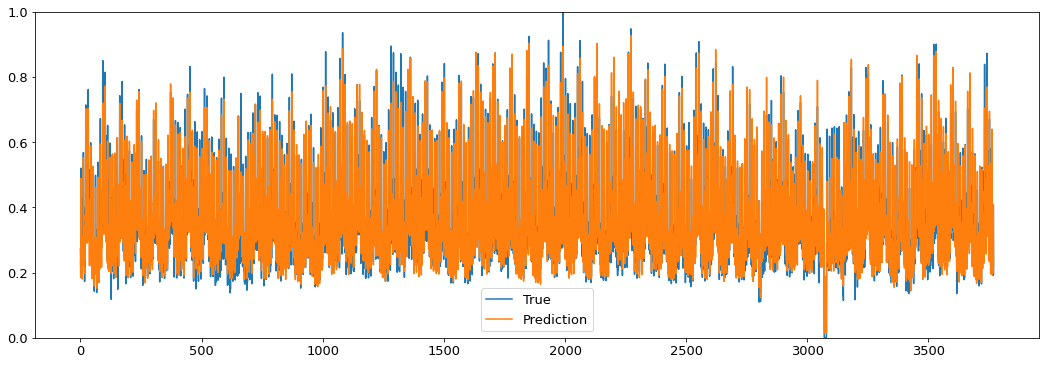

In [6]:
f, ax = plt.subplots(1, 1, figsize=(18, 6))
ax.plot(val['demand'].values, label="True")
ax.plot(y_pred, label="Prediction")
ax.legend()
ax.set_ylim(0, 1)
plt.show()

In [7]:
y_pred_df = lightgbm_pred_to_df(y_pred, val)
y_pred_df

,id,date,lgb_pred,demand
0,CA_1_X,2013-02-21,0.233479,0.273193
1,CA_1_X,2013-02-22,0.184261,0.221680
2,CA_1_X,2013-02-23,0.488599,0.520020
3,CA_1_X,2013-02-24,0.222362,0.213745
4,CA_1_X,2013-02-25,0.201243,0.245483
...,...,...,...,...
3765,WI_3_X,2014-02-28,0.255387,0.239990
3766,WI_3_X,2014-03-01,0.312931,0.292480
3767,WI_3_X,2014-03-02,0.200842,0.191162
3768,WI_3_X,2014-03-03,0.409037,0.406494


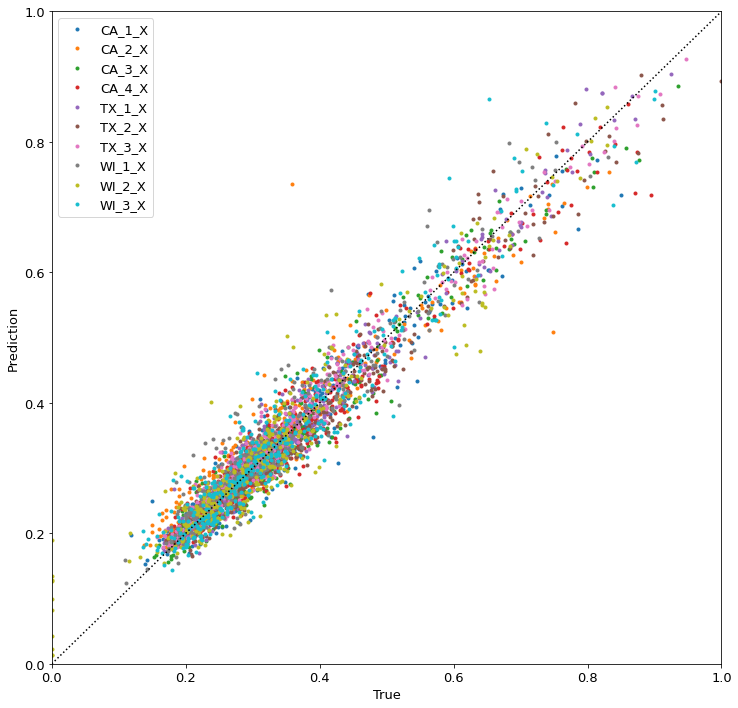

In [8]:
f, ax = plt.subplots(1, 1, figsize=(12, 12))
for store_id in y_pred_df.id.unique():
    df = y_pred_df[y_pred_df.id == store_id]
    ax.plot(df['demand'].values, df['lgb_pred'].values, ".", label=store_id)
ax.plot(np.linspace(0, 1), np.linspace(0, 1), ':', color='k')
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_xlabel("True")
ax.set_ylabel("Prediction")
ax.legend()
plt.show()

## All levels

In [10]:
for level in range(1, 11+1):
    print("========== Starting level {} ==========".format(level))
    pred_list = []
    for fold in range(1, 1+5):
        print("== Starting fold {} ==".format(fold))
        # read
        train, val, test, features = get_train_val_slit(level, fold, verbose=False)
        model = lgb.Booster(model_file=model_dir + "lightgbm-level{}-fold{}.txt".format(level, fold))

        # predict
        y_pred = model.predict(val[features])
        y_pred_df = lightgbm_pred_to_df(y_pred, val)
        pred_list.append(y_pred_df)
    
        # predict test set with model trained on fold 5 (i.e. with validation set longest ago)
        if fold == 5:
            # predict
            y_pred = model.predict(test[features])
            y_pred_df = lightgbm_pred_to_df(y_pred, test)
            pred_list.append(y_pred_df)

    pred_df = pd.concat(pred_list)
    pred_df.to_csv(model_dir + "predictions_level{}.csv".format(level))

========== Starting level 1 ==========
== Starting fold 1 ==
== Starting fold 2 ==
== Starting fold 3 ==
== Starting fold 4 ==
== Starting fold 5 ==
========== Starting level 2 ==========
== Starting fold 1 ==
== Starting fold 2 ==
== Starting fold 3 ==
== Starting fold 4 ==
== Starting fold 5 ==
========== Starting level 3 ==========
== Starting fold 1 ==
== Starting fold 2 ==
== Starting fold 3 ==
== Starting fold 4 ==
== Starting fold 5 ==
========== Starting level 4 ==========
== Starting fold 1 ==
== Starting fold 2 ==
== Starting fold 3 ==
== Starting fold 4 ==
== Starting fold 5 ==
========== Starting level 5 ==========
== Starting fold 1 ==
== Starting fold 2 ==
== Starting fold 3 ==
== Starting fold 4 ==
== Starting fold 5 ==
========== Starting level 6 ==========
== Starting fold 1 ==
== Starting fold 2 ==
== Starting fold 3 ==
== Starting fold 4 ==
== Starting fold 5 ==
========== Starting level 7 ==========
== Starting fold 1 ==
== Starting fold 2 ==
== Starting fold 3 ==
=